In [266]:
import numpy as np
import tensorflow as tf
from stochastic.processes.continuous import FractionalBrownianMotion
import fbm
from fbm import mbm,mgn,times
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib notebook

In [252]:
def gen_fbm_data(nsamples, ntimes, hurst_const=None):
    """ 
    Function to produce fractional brownian motion data for neural network 
    training and testing
    Inputs: nsamples; number of samples, ntimes; number of times (= number of steps)
    Outputs: traindata; training data for NN, trainlabels; labels associated 
            with traindata
    """
    #data = np.empty((nsamples,ntimes+1,3))
    data_x = np.empty((nsamples,ntimes+1))
    data_y = np.empty((nsamples,ntimes+1))
    data_z = np.empty((nsamples,ntimes+1))
                              
    labels = np.empty((nsamples,1))
    for i in range(0,nsamples):
        if hurst_const == None:
            hurst_exp = np.random.uniform(0.,1.)
        else:
            hurst_exp = hurst_const
        fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
        x = fbm.sample(ntimes)
        y = fbm.sample(ntimes)
        z = fbm.sample(ntimes)
        #apply differencing and normalization on the data
        #dx = (x[1:]-x[0:-1])/(np.amax(x)-np.amin(x))
        #dy = (y[1:]-x[0:-1])/(np.amax(y)-np.amin(y))
        #dz = (z[1:]-x[0:-1])/(np.amax(z)-np.amin(z))
        #data[i,:] = np.array([x,y,z]).transpose()
        data_x[i,:] = x
        data_y[i,:] = y
        data_z[i,:] = z
        labels[i,:] = hurst_exp
        
    return data_x, data_y, data_z, labels

def gen_fbm_track(ntimes, hurst_const=None, initial_position=(0,0,0)):
                              
    if hurst_const == None:
        hurst_exp = np.random.uniform(0.,1.)
    else:
        hurst_exp = hurst_const
    fbm = FractionalBrownianMotion(hurst=hurst_exp,t=1,rng=None)
    x = fbm.sample(ntimes)
    y = fbm.sample(ntimes)
    z = fbm.sample(ntimes)

    x0, y0, z0 = initial_position
    x, y, z = x+x0, y+y0, z+z0
        
    return x, y, z

def track_until_reflection(xs, ys, zs, radius):
    
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
        xs = xs[:i]
        ys = ys[:i]
        zs = zs[:i]
    return xs, ys, zs

#def normalize(x,y,z):

def exit_step(xs, ys, zs, radius):
    
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
        dx = xs[i+1]-xs[i]
        dy = ys[i+1]-ys[i]
        dz = zs[i+1]-zs[i]
    return dx, dy, dz

def exit_coords(xs, ys, zs, radius):
    
    indices = np.argwhere(xs**2+ys**2>radius**2).ravel()
    if len(indices)>0:
        i = indices[0]
        xs = xs[i:i+1]
        ys = ys[i:i+1]
        zs = zs[i:i+1]
    return xs, ys, zs

def gradient(xs, ys):
    
    return (ys[1]-ys[0])/(xs[1]-xs[0])

def get_roots(xs, ys, r):
    
    x1,x2 = xs
    y1,y2 = ys
    
    m = gradient(xs, ys)
    a = m**2+1
    b = 2*m*(y1-m*x1)
    c = (m**2)*(x1**2) - 2*m*y1*x1 + y1**2 - r**2
    
    x_roots = np.roots([a,b,c])
    y_roots = m*(x_roots-x1)+y1
    
    return x_roots, y_roots

def intersection_point(xs, ys, r):
    
    x_roots, y_roots = get_roots(xs, ys, r)
    i = np.argmin((xs[1]-x_roots)**2+(ys[1]-y_roots)**2)
    
    return x_roots[i], y_roots[i]

def get_mod(v):
    
    return np.sqrt(np.dot(v,v))

def get_exit_angle(xs,ys,r):
    
    r_vector = np.array([intersection_points(xs,ys,r)])
    exit_vector = np.array([xs[1]-xs[0],ys[1]-ys[0]])
    
    rmod = get_mod(r_vector)
    exit_mod = get_mod(exit_vector)
    
    cos_theta = np.dot(r_vector,exit_vector)/(rmod*exit_mod)
    
    return np.arccos(cos_theta)

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy
    
    
def gen_fbm_track_collisions(hurst_exp, radius, ntimes, initial_pos=(0,0,0)):
    
    data_x, data_y, data_z = gen_fbm_track(ntimes, hurst_exp, initial_pos)
    
    data_x, data_y, data_z = track_until_reflection(data_x, data_y, data_z, radius)
    
    initial_pos_array = np.empty((3,))
    
    while len(data_x) < ntimes:
        
        #subtrack_length = ntimes - len(data_x)
        new_initial_pos = (data_x[-1], data_y[-1], data_z[-1])
        initial_pos_array = np.vstack((initial_pos_array, new_initial_pos))
        
        #x, y, z = gen_fbm_track(subtrack_length, hurst_exp, initial_position=new_initial_pos)
        x, y, z = gen_fbm_track(ntimes, hurst_exp, initial_position=new_initial_pos)
        
        new_x = np.append(data_x, x)
        new_y = np.append(data_y, y)
        new_z = np.append(data_z, z)
        
        data_x, data_y, data_z = track_until_reflection(new_x, new_y, new_z, radius)   

    return data_x, data_y, data_z, np.unique(initial_pos_array, axis=0)
    

In [253]:
def plot_random_walk_single(data_x, data_y, data_z, init_pos=[0,0,0]):
    
    #fig = plt.figure()
    #ax = Axes3D(fig)
#     for i in range(len(data_x)):  # plotting each track
#         ax.plot(data_x[i,:],data_y[i,:],data_z[i,:])
    ax.plot(data_x, data_y, data_z)
    ax.scatter(data_x[0], data_y[0], data_z[0], color='black')
    ax.scatter(data_x[-1], data_y[-1], data_z[-1], color='green')

In [254]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z/2, height_z/2, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

def plot_cylinder_along_z(center_x, center_y, radius, height_z):
    Xc,Yc,Zc = data_for_cylinder_along_z(center_x, center_y, radius, height_z)
    ax.plot_surface(Xc, Yc, Zc, alpha=0.1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-1.5*radius, 1.5*radius)
    ax.set_ylim(-1.5*radius, 1.5*radius)
    #ax.set_zlim(-1.5*radius, 1.5*radius)

In [255]:
def plot_random_walks(data_x, data_y, data_z):
    
    for i in range(len(data_x)):  # plotting each track
        ax.plot(data_x[i,:],data_y[i,:],data_z[i,:])
        
def get_rand_initial_pos(radius, z_lim=None):
    
    if z_lim==None:
        z_lim = [-radius, radius]
        
    x0, y0 = np.random.uniform(-radius, radius, 2)
    z0 = np.random.uniform(-z_lim[0], z_lim[1], 1)
    
    while x0**2+y0**2 > radius**2:
        x0, y0 = np.random.uniform(-radius, radius, 2)
        z0 = np.random.uniform(-z_lim[0], z_lim[1], 1)
    
    return x0, y0, z0
    
def gen_all_tracks(nsamples, ntimes, hurst_exp, radius, xy_centre=(0,0), height_z=None, initial_pos=None, plot=True):
    
    data_x = np.empty((nsamples,ntimes+1))
    data_y = np.empty((nsamples,ntimes+1))
    data_z = np.empty((nsamples,ntimes+1))
    
    for i in range(0, nsamples):
        if initial_pos==None:
            initial_pos = get_rand_initial_pos(radius)
        data_x[i,:], data_y[i,:], data_z[i,:] = gen_fbm_track_collisions(hurst_exp, radius, ntimes, initial_pos=initial_pos)
        
    if plot:
        fig = plt.figure()
        ax = Axes3D(fig, auto_add_to_figure=False)
        fig.add_axes(ax)
        if height_z==None:
            height_z = 2*np.max(np.abs(data_z))
        plot_cylinder_along_z(xy_centre[0], xy_centre[1], radius, height_z)
        plot_random_walks(data_x, data_y, data_z)

In [265]:
#gen_all_tracks(3, 20, 0.8, 1, xy_centre=(0,0), height_z=5, initial_pos=(0,0,0), plot=True)

In [257]:
#initial_pos_array

In [258]:
#np.unique(initial_pos_array, axis=0)

<IPython.core.display.Javascript object>


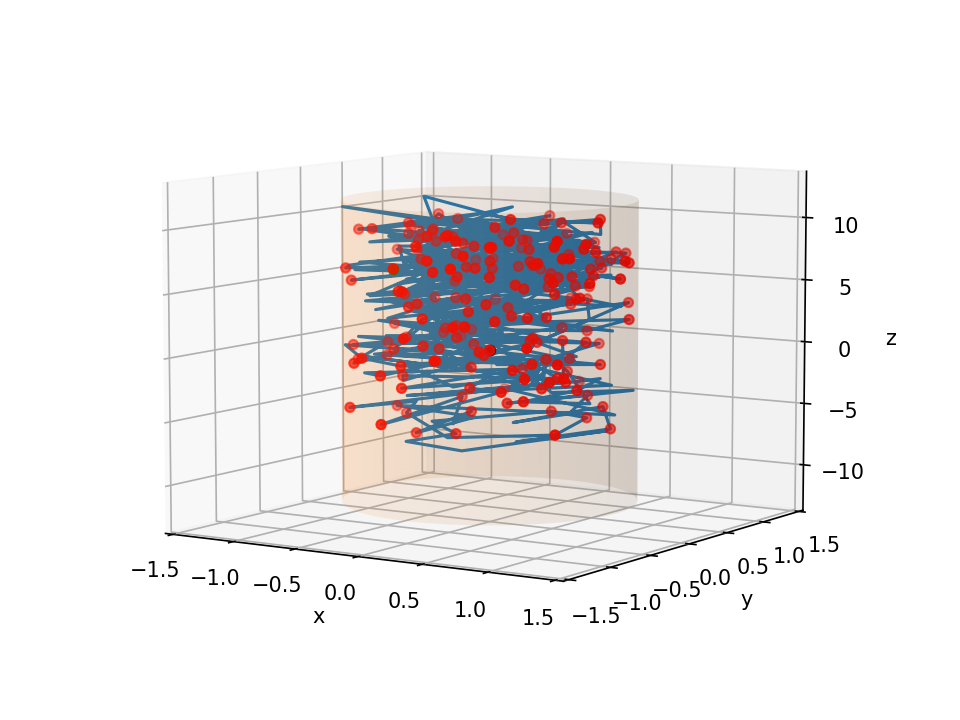

In [259]:
h = 0.01
r = 1
nsteps = 1000
data_x, data_y, data_z, initial_pos_array = gen_fbm_track_collisions(h, r, nsteps, initial_pos=(0,0,0))

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

plot_random_walk_single(data_x, data_y, data_z)
plot_cylinder_along_z(data_x[0], data_y[0], r, 2*np.max(np.abs(data_z)))
ax.scatter(xs=initial_pos_array[:,0], ys=initial_pos_array[:,1], zs=initial_pos_array[:,2], color='r')

<IPython.core.display.Javascript object>


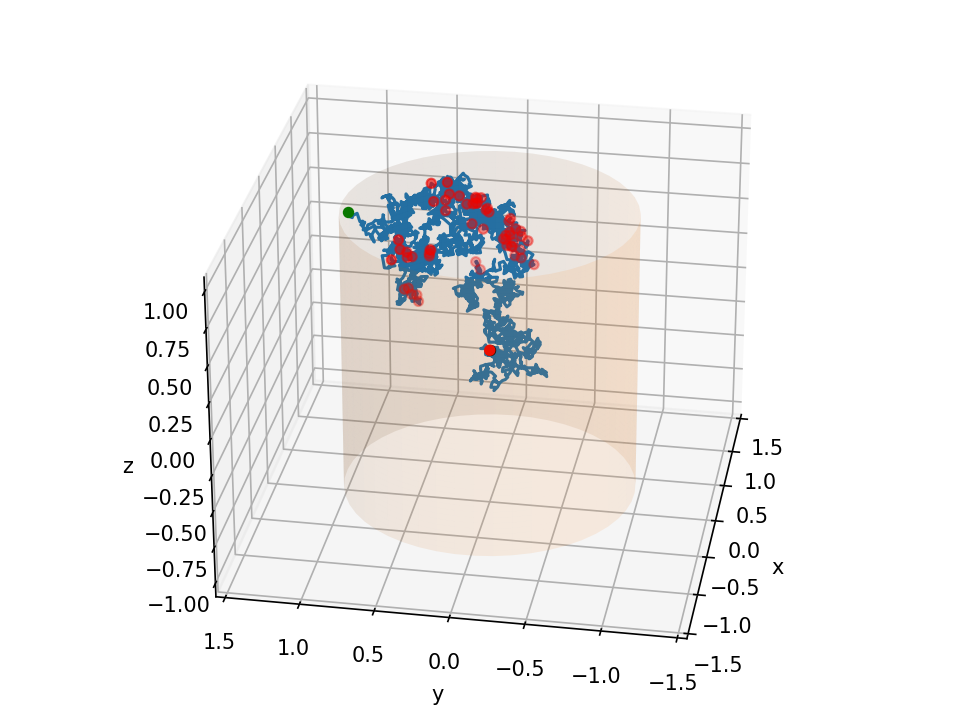

In [260]:
h = 0.5
r = 1
nsteps = 3000
data_x, data_y, data_z, initial_pos_array = gen_fbm_track_collisions(h, r, nsteps, initial_pos=(0,0,0))

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

plot_random_walk_single(data_x, data_y, data_z)
plot_cylinder_along_z(data_x[0], data_y[0], r, 2*np.max(np.abs(data_z)))
ax.scatter(xs=initial_pos_array[:,0], ys=initial_pos_array[:,1], zs=initial_pos_array[:,2], color='r')

<IPython.core.display.Javascript object>


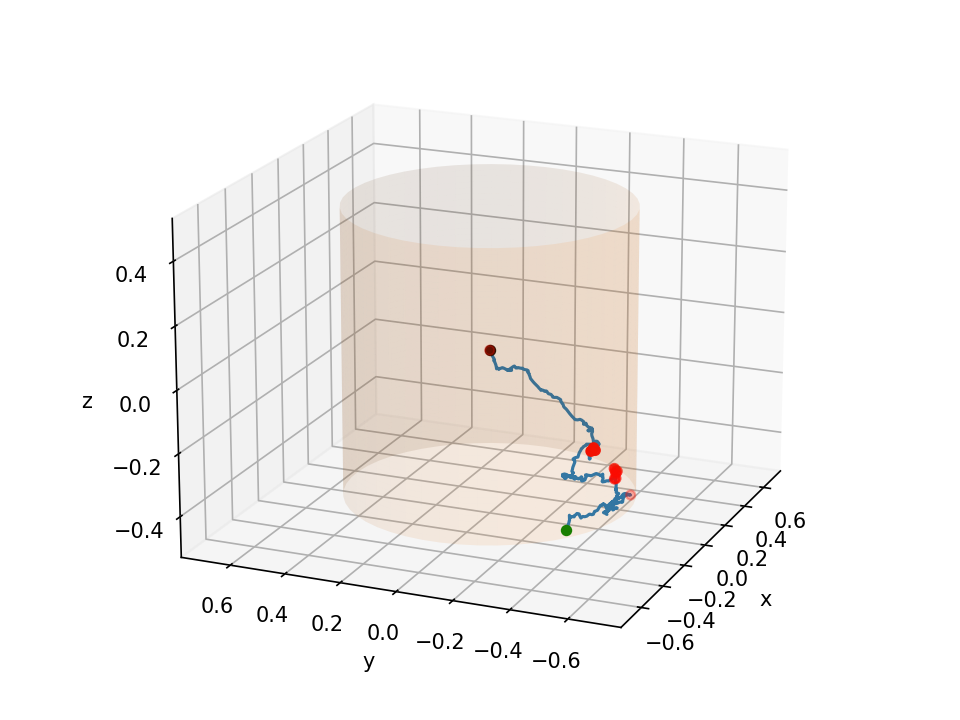

In [263]:
h = 0.9
r = 0.5
nsteps = 500
data_x, data_y, data_z, initial_pos_array = gen_fbm_track_collisions(h, r, nsteps, initial_pos=(0,0,0))

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

plot_random_walk_single(data_x, data_y, data_z)
plot_cylinder_along_z(data_x[0], data_y[0], r, 2*np.max(np.abs(data_z)))
ax.scatter(xs=initial_pos_array[:,0], ys=initial_pos_array[:,1], zs=initial_pos_array[:,2], color='r')

In [241]:
initial_pos_array

array([[-0.66666675, -0.66666675,  0.33333299],
       [ 0.15834497,  0.97692676, -0.65999054],
       [ 0.17559535,  0.98362091, -0.6237738 ],
       [ 0.20187312,  0.97812301, -0.61388681],
       [ 0.20709752,  0.97584055, -0.73893102],
       [ 0.20925738,  0.97237107, -0.62526925],
       [ 0.21402017,  0.97157141, -0.58966448],
       [ 0.24741136,  0.96483418, -0.59824421],
       [ 0.25170514,  0.96097178, -0.59851131],
       [ 0.27323864,  0.96160474, -0.55383196],
       [ 0.28644687,  0.95444054, -0.57031612]])

In [40]:
def h_sine(t):
    
    h_val = 0.5+0.4*np.sin(2*np.pi*t)
    
    return h_val

def h_step(t):
    
    print(max(t))
    
    h_val = np.piecewise(t, [t < max(t)//2, t >= max(t)//2], 
                         [lambda t: (t)//max(t), lambda t: 1-t//max(t)])

    return h_val
 
#m = mbm(n=1000, hurst=h_step, length=100, method='riemannliouville')
t = times(n=1000,length=100)

In [ ]:
#plt.plot(t,m)
plt.plot(t,h_step(t))